<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/week3x/Assignment_3x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports

In [ ]:
import numpy as np
import math
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary 

## 2. Importing Data

In [ ]:
# let's extend the Dataset class of Pytorch to build our own sample dataset
from torch.utils.data import Dataset
class OHLC(Dataset):
  def __init__(self, csv_file):
    self.data = pd.read_csv(csv_file)

  def __getitem__(self, index):
    r = self.data.iloc[index]
    label = torch.tensor(r.is_up_day, dtype=torch.long)
    sample = self.normalize(torch.tensor([r.open, r.high, r.low, r.close]))
    return sample, label
  
  def __len__(self):
    return len(self.data)

In [ ]:
#3 Working emnist data
# now let's work with EMnist

train_set = torchvision.datasets.EMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,split='balanced'
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [ ]:
# using data loader to load the data batch and shuffle
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=10
    ,shuffle=True
)

In [ ]:
len(train_set)

112800

In [ ]:
(train_set.train_labels).unique()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [ ]:
train_set.train_labels.bincount() #frequency of each label, we have balanced class here

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400])

In [ ]:
2400*47

112800

In [ ]:
for e in train_set:
  print(e)
  break

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
          0.0275, 0.1255, 0.1412, 0.0824, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314,
          0.1294, 0.4431, 0.4863, 0.3176, 0.0863, 0.0275, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
sample = next(iter(train_set))

len(sample)


2

In [ ]:
image, label = sample
print(image.shape)

torch.Size([1, 28, 28])


label: 45


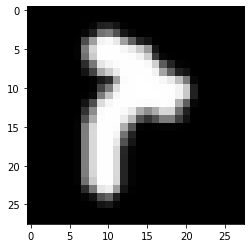

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [ ]:
batch = next(iter(train_loader))

len(batch), type(batch)

(2, list)

In [ ]:
images, labels = batch

In [ ]:
image.shape, labels.shape

(torch.Size([1, 28, 28]), torch.Size([10]))

labels: tensor([14, 28, 23,  6, 20,  7,  5,  1, 35, 25])


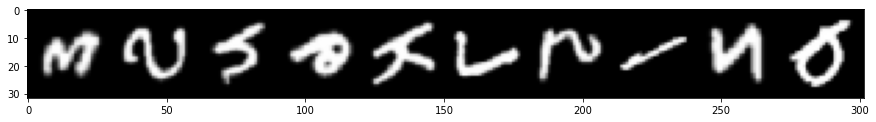

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

## 3. Building a network

In [ ]:
## getting the batch aize in place
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=64
    ,shuffle=True
)

In [ ]:
## Defining the network - skeleton

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = None

    def forward(self, t):
        t = self.layer(t)
        return t

In [ ]:
## Defining the network - actual
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3) #  1x28x28 -> 10x26x26 rf-3x3
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3) #  10x26x26 -> 10x24x24 rf -5x5 
        self.pool1 = nn.MaxPool2d(2, 2)#  10x24x24 -> 10x12x12 rf- 10x10

        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3) #  10x12*12 -> 20x10x10 rf - 12x12
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3) #  20x10x10 -> 20x8x8 rf - 14x14
        self.pool2 = nn.MaxPool2d(2, 2)#  20x8x8 -> 20x4x4 rf - 28x28

        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3) #  20x4x4 -> 30x2x2 rf - 30x30
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=47, kernel_size=1) #  30x2x2 -> 47x2x2 rf - 30x30



    def forward(self, t):
        # implement the forward pass
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(t)))))                #The forward function computes output Tensors from input Tensors.
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = (self.conv6(F.relu(self.conv5(x))))

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(-1, 47)
        
        return F.log_softmax(x)


In [ ]:
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(30, 47, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:

#summary(network, input_size=(1, 28, 28)) 

In [ ]:
torch.set_grad_enabled(True)

## 4. Training process

In [ ]:
from tqdm import tqdm  #load the library to display progress bar
def train(model, device, train_loader, optimizer, epoch): #defining the model training function
    model.train() # Activating the model traing mode. Layers like BatchNorm, Dropout working differently in training and validation
    pbar = tqdm(train_loader) #loading the pytorch data loader in a tqdm wrapper 
    for batch_idx, (data, target) in enumerate(pbar): #looping over the tqdm data wrapper. This gives each batch(size of 128 images) over which we want calaculate gradient  

        data, target = data.to(device), target.to(device) #Pushing the images and target to GPU
        optimizer.zero_grad() #Initializing the gradient of all parameters to Zero 
        output = model(data) #Run the forward pass using current parameter values and calculate the output  
        loss = F.nll_loss(output, target) #Calculate the negative log likelihood loss for the output and target 
        loss.backward() #Calculate gradient (dloss/dx) for all trainable parameters and stores the gradients  
        optimizer.step() #Update the parameter values using the optimizer lerning rate and momentum 
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}') #display the loss value for each batch with batch number



In [ ]:
use_cuda = torch.cuda.is_available() #create a boolean to check if GPU is available 
device = torch.device("cuda" if use_cuda else "cpu")
model =  Network().to(device) #Pushing the model to GPU
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #Initializing the optimizer stochastic gradient descent with momentum, here learning rate is 0.01 and momentum is 0.9 

for epoch in range(1, 20): #looping the entire data 1 time as we are using range(1,2)
   train(model, device, train_loader, optimizer, epoch) #Train the model
   #test(model, device, test_loader) #Test the model

loss=0.15409663319587708 batch_id=1762: 100%|██████████| 1763/1763 [00:21<00:00, 81.04it/s]
